In [ ]:
%%bash
#pip install https://github.com/hadim/anamic/archive/f35713231804e0a35fec3c92f894a36ec8009453.zip

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json

import anamic

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from skimage.exposure import rescale_intensity
import skimage.util as util

import tifffile
import read_roi
import tqdm
from tkinter import filedialog


In [4]:
def open_roi_line(path):
    roi_data = read_roi.read_roi_zip(path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [356]:
# Open the image and its starting points for fitting
fname = filedialog.askopenfilename()
data_dir = Path(fname).parents[0]

           Track ID     x1     x2     y1    y2
0  0001-0039-0064-1  52.50  75.25  40.50  36.5
1    0001-0039-0064  52.75  75.25  40.25  36.5


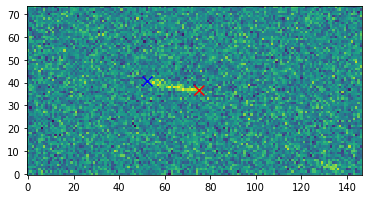

In [393]:

testname = 'test84'
#2020-02-28 ch2 100nM DZA 10uM tubulin 2pt5 spf FFT PFF driftcorr-1
#0029-0034-0033
#2020-02-28 dmso 10uM tubulin 2pt5 spf backsub FFT PFF-5
#0001-0037-0055
#2020-02-28 100nM taxol 10uM tubulin 2pt5 spf processed and driftcorr-2
#0001-0060-0127

pixel_size = 107  # nm

dt = 5050  # ms

n = 1 #Frames to average

#rois = read_roi.read_roi_zip('20190718-ch3-midmt.zip')
#rois = read_roi.read_roi_zip(fname.with_suffix(".zip"))
    
rois = open_roi_line(data_dir/('kymolines.zip'))
roi = rois
print(roi)
#roi = rois['0001-0060-0127']

# tip_start = np.array([roi['y1'], roi['x1']])
# tip_end = np.array([roi['y2'], roi['x2']])

# Get microtubule tip coordinates
tip_start = np.array([roi['y2'], roi['x2']])
tip_end = np.array([roi['y1'], roi['x1']])
    
tip_start = np.transpose(tip_start)[0]
tip_end = np.transpose(tip_end)[0]

# Make array so plotting is easier
initial_points = np.array([tip_start, tip_end])

# Open the image
stack = tifffile.imread(str(fname))

# Average every n frames to increase SNR.
stack = np.array([stack[i::n] for i in range(n)]).sum(axis=0) / n
stack = rescale_intensity(stack, out_range='uint16').astype('uint16')
stack = util.invert(stack)
#if n != 1:
#    tifffile.imsave(fname.with_suffix('_' + str(n) + 'x_AVERAGED.tif'), stack)

new_dt = dt * n

frame = 0

plt.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
plt.scatter(initial_points[:, 1], initial_points[:, 0], color=['r','b'], s=100, marker="x")

## Single Image Fit (to find optimal parameters)

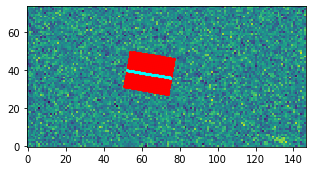

In [394]:
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] =  1  # pixel
args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1 # pixel

lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args['get_thick_line_args'])

# Check the new points.
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(lines[1], lines[0], color='red', s=20, marker=".")



middle_index = int(lines.shape[1] / 2)
ax.scatter(lines[1, middle_index], lines[0, middle_index], color='cyan', s=20, marker=".")

C:\ProgramData\Anaconda3\lib\site-packages\anamic\fitter.py:169: RuntimeWarning: invalid value encountered in less
  fitted_line = fitted_line[errors < mu_stderr_threshold]


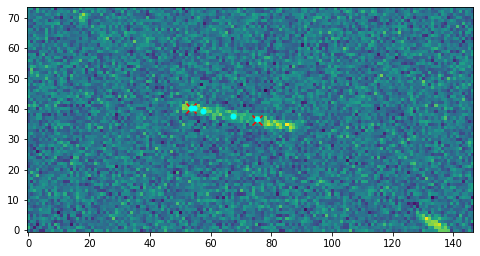

In [423]:
args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.2
args['perpendicular_line_fit_args']['continuous_discard'] = False

fitted_line = anamic.fitter.perpendicular_line_fit(lines, stack[frame],
                                                   **args['perpendicular_line_fit_args'])

# Now we fit the best line from those points, get fitted tip and end
a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
fit_point_start = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
fit_point_end = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

# Make array so plotting is easier
fit_points = np.array([fit_point_start, fit_point_end])


# Check the fitted points
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(fit_points[:, 1], fit_points[:, 0], color='red', s=100, marker="x")
ax.scatter(fitted_line[:, 1], fitted_line[:, 0], color='cyan', s=100, marker=".")


#ax.scatter(initial_line[:, 1], initial_line[:, 0], color='red', s=100, marker="x")

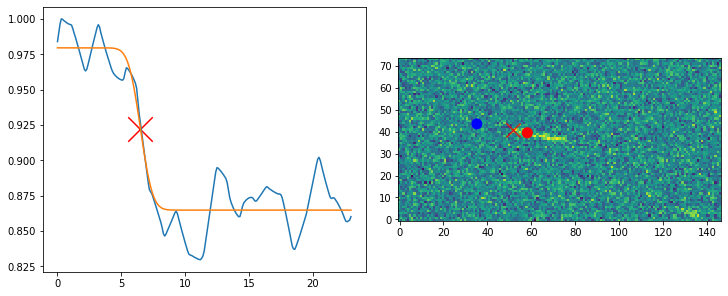

In [427]:
# Now we fit the microtubule using a line profile with a defined thickness.
i=1
frame = 0
args['offset_start'] = 500 / pixel_size  # pixel
args['offset_end'] = 2000 / pixel_size  # pixel

# Calculate the vector of the line and its norm
vec = ((-1)**i)*(fit_points[0] - fit_points[1])

# Get the coordinates of the points we'll use
# to for line fitting.
offset_start = anamic.geometry.get_point_from_vector(-vec, fit_points[i], args['offset_start'])
offset_end = anamic.geometry.get_point_from_vector(vec, fit_points[i], args['offset_end'])

offset_fit_tips = np.array([offset_start, offset_end])

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

x, profile, fit_result, fit_func = anamic.fitter.tip_line_fit(offset_fit_tips[0],
                                                                        offset_fit_tips[1],
                                                                        stack[frame],
                                                                        **args['tip_fit_args'])
fit_values = fit_result.values

mu = fit_values['mu']
tip_position = anamic.geometry.get_point_from_vector(vec, offset_fit_tips[0], mu)

profile_fit = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)
ax1.plot(x, profile, label='data')
ax1.plot(x, profile_fit, label='fit')
ax1.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

ax2.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
ax2.set_aspect('equal')
ax2.scatter(offset_fit_tips[:, 1], offset_fit_tips[:, 0], color=['red','b'], s=100, marker="o")
ax2.scatter(tip_position[1], tip_position[0], color='red', s=200, marker="x", alpha=0.8)

In [425]:
start_tip = tip_position
start_tip

array([36.24312606, 76.32645035])

In [428]:
end_tip = tip_position
end_tip

array([40.58605374, 51.792113  ])

In [429]:
fit_points = np.array([start_tip, end_tip])

In [419]:
def get_tip_possition_append(fit_points,frame,i):  
    # Now we fit the microtubule using a line profile with a defined thickness.
    args['offset_start'] = 1500 / pixel_size  # pixel
    args['offset_end'] = 1000 / pixel_size  # pixel

    # Calculate the vector of the line and its norm
    vec = ((-1)**i)*(fit_points[0] - fit_points[1])

    # Get the coordinates of the points we'll use
    # to for line fitting.
    offset_start = anamic.geometry.get_point_from_vector(-vec, fit_points[i], args['offset_start'])
    offset_end = anamic.geometry.get_point_from_vector(vec, fit_points[i], args['offset_end'])

    offset_fit_tips = np.array([offset_start, offset_end])

    args['tip_fit_args'] = {}
    args['tip_fit_args']['length_spacing'] = 0.1  # pixel
    args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
    args['tip_fit_args']['width_spacing'] = 0.1  # pixel

    x, profile, fit_result, fit_func = anamic.fitter.tip_line_fit(offset_fit_tips[0],
                                                                            offset_fit_tips[1],
                                                                            stack[frame],
                                                                            **args['tip_fit_args'])
    fit_values = fit_result.values

    mu = fit_values['mu']
    tip_position = anamic.geometry.get_point_from_vector(vec, offset_fit_tips[0], mu)

    profile_fit = fit_func(x, **fit_values)
        
    return tip_position

In [430]:
for frame in np.arange(0,len(stack)-1):
    for i in [0,1]:
        tip_position = get_tip_possition_append(fit_points,frame,i)
        if i==0:
            start_tip = np.vstack((start_tip, tip_position))
        elif i==1:
            end_tip = np.vstack((end_tip, tip_position))
    fit_points = np.array([start_tip[-1], end_tip[-1]])
    

In [436]:
dist = []
for i in np.arange(0,len(start_tip)-1):
    dist0 = np.linalg.norm(start_tip[i]-start_tip[0])
    dist = np.append(dist,dist0*0.107)

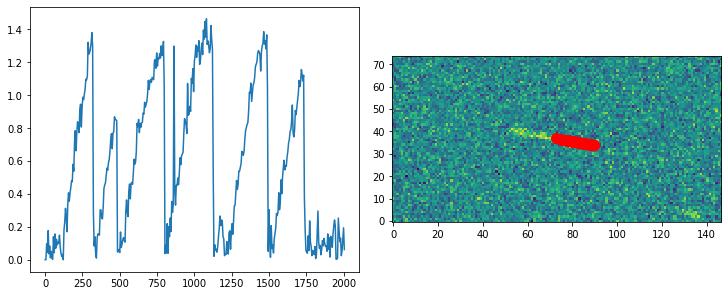

In [437]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)
ax1.plot(np.arange(0,len(start_tip)-1)*5.05,dist)

ax2.imshow(stack[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax2.set_aspect('equal')
ax2.scatter(start_tip[:, 1], start_tip[:, 0], color=['red'], s=100, marker="o")

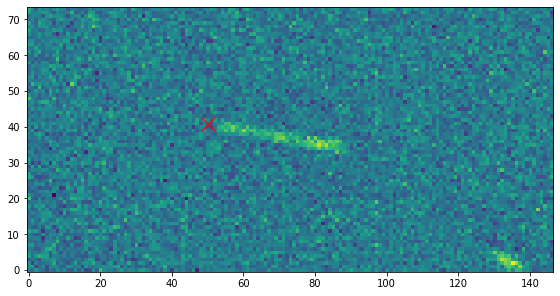

In [403]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.imshow(stack[200], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
#ax.scatter(offset_fit_tips[:, 1], offset_fit_tips[:, 0], color=['red','b'], s=100, marker="o")
ax.scatter(tip_position[1], tip_position[0], color='red', s=200, marker="x", alpha=0.8)

## Batch Fit (all timepoints)

IndexError: index 32331 is out of bounds for axis 0 with size 399

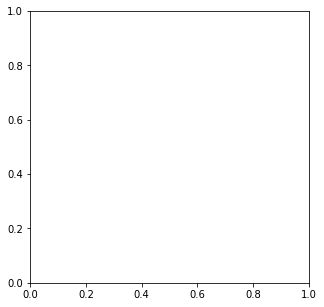

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
image = util.invert(stack[image[0]])
ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')

In [23]:
# IMPORTANT: take into account the number of averaged frames.
frame_start = 0
frame_end = len(stack)-1
# frame_start = 730
# frame_end = 740

args = {}
args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 2  # pixel
args['get_thick_line_args']['line_thickness'] = 3000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel
args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.2
args['perpendicular_line_fit_args']['continuous_discard'] = False
args['offset_start'] = 1000 / pixel_size  # pixel
args['offset_end'] = 1000 / pixel_size  # pixel
args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

data = []

current_point = new_point2

tip_position = tip_end
tip_position_minusoff = tip_start

x_profiles = []
y_profiles = []

for i, frame in enumerate(tqdm.trange(frame_start, frame_end)):
    
    
    image = util.invert(stack[frame])

    lines = anamic.fitter.get_thick_line(tip_position_minusoff, tip_position, **args['get_thick_line_args'])

    fitted_line = anamic.fitter.perpendicular_line_fit(lines, image,
                                                       **args['perpendicular_line_fit_args'])

    # Now we fit the best line from those points
    a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
    new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
    new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])
    
#     ####################
#     fig, ax = plt.subplots(figsize=(5, 5))

#     ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
#     ax.set_aspect('equal')

#     #ax.scatter(lines[1, 0], lines[0, 0], color='red', s=20, marker=".")
#     #ax.scatter(lines[1, -1], lines[0, -1], color='red', s=20, marker=".")

#     middle_index = int(lines.shape[1] / 2)
#     ax.scatter(lines[1, middle_index], lines[0, middle_index], color='orange', s=20, marker=".")
#     plt.show()
#     ####################

    # This the new line defining the microtubule
    new_line = np.array([new_point1, new_point2])

    # Calculate the vector of the line and its norm
    vec = new_point2 - new_point1

    start_point = anamic.geometry.get_point_from_vector(-vec, current_point, args['offset_start'])
    end_point = anamic.geometry.get_point_from_vector(vec, current_point, args['offset_end'])
    line_fit_tips = np.array([start_point, end_point])

    x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0],
                                                                            line_fit_tips[1],
                                                                            image,
                                                                            **args['tip_fit_args'])
    fit_values = fit_result.values

    mu = fit_values['mu']
    sigma = fit_values['sigma']
    mt = fit_values['mt']
    bg = fit_values['bg']
    
    #print(mu*pixel_size/1000)
    
    tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
  
    datum = {}
    datum['x'] = tip_position[0]
    datum['y'] = tip_position[1]
    datum['index'] = i
    datum['frame'] = frame
    datum['time'] = i * new_dt
    datum['mu'] = mu
    datum['sigma'] = sigma
    datum['mt'] = mt
    datum['bg'] = bg
    datum['tip_start[0]'] = tip_start[0]
    datum['tip_start[1]'] = tip_start[1]
    data.append(datum)
    
    x_profiles.append(x_profile)
    y_profiles.append(y_profile)
    
    
    current_point = [tip_position[0],tip_position[1]]
    
    
data = pd.DataFrame(data)
data.to_csv(fname.with_suffix('.csv'), index=False)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


TypeError: expected non-empty vector for x

In [148]:
# Read the data
data = pd.read_csv(fname.with_suffix('.csv'))
data = data.set_index('frame')


114.25527249293351 23.74224743132072 111.0 100


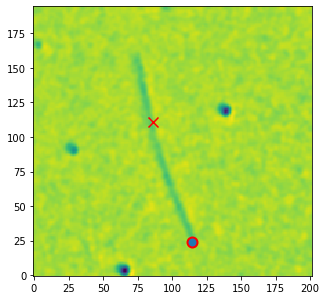

In [149]:
# Visualize frames one by one
frame = 100

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

tip_start0 = data.loc[frame, 'tip_start[0]']
tip_start1 = data.loc[frame, 'tip_start[1]']
ax.scatter(tip_start1, tip_start0, color='red', s=100, marker="x")

x, y = data.loc[frame, ['y', 'x']]
ax.scatter(x, y, s=100, marker="o", edgecolors = 'r', linewidth = 2)
#ax.plot([tip_start1, x], [tip_start0,y], color = 'k')

#ax.text(0.75, 0.9, f"{data.loc[frame, 'time_s']:2.2f} s",
#        transform=ax.transAxes, color='#ffffff', fontsize=15)


print(x, y, tip_start0, frame)

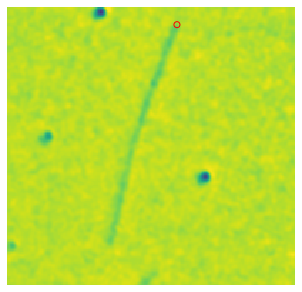

In [150]:
# Make a movie

movie_fps = 18  # frame/sec
image_size = 4
movie_dpi = 200

movie_start = frame_start
movie_end = frame_end

FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=movie_fps)

fig, ax = plt.subplots(figsize=(image_size, image_size))
mpl_im = ax.imshow(stack[movie_start], aspect='equal', interpolation='none')
mpl_tip = ax.scatter([], [], color='red',marker='o', facecolors='none')
mpl_text = ax.text(0.75, 0.9, "", transform=ax.transAxes, color='#ffffff', fontsize=34)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

#with writer.saving(fig, fname.with_suffix('.mp4'), movie_dpi):
with writer.saving(fig, f'{testname}.mp4', movie_dpi):
    for frame in range(movie_start, movie_end):
        mpl_im.set_data(stack[frame])
        mpl_tip.set_offsets(data.loc[frame, ['y', 'x']].values)
        #mpl_text.set_text(f"{data.loc[frame, 'time_s']:2.2f} s")
        writer.grab_frame()

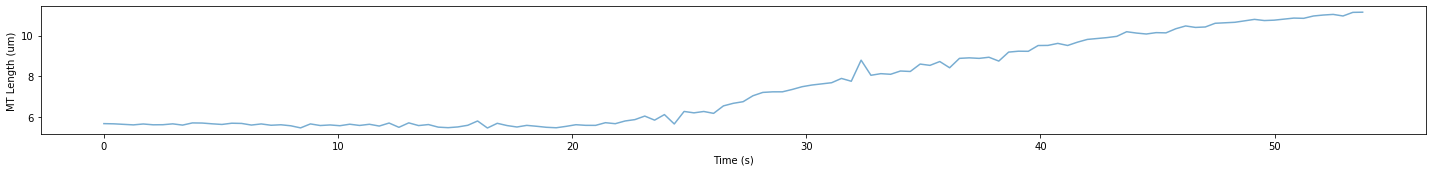

In [151]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

# if data.index.name == 'frame':
#     data = data.reset_index()
# data.to_csv(fname.with_suffix('.csv'), index=False)
# if data.index.name != 'frame':
#     data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(20, 2.5))
#ax.scatter(data['time_s'], data['length_um'],marker='o',facecolor='',edgecolor='b',linewidth=1.5,s=60,alpha=0.4)
plt.plot(data['time_s'], data['length_um'],linewidth=1.5,alpha=0.6)

#ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
#plt.xlim(-1,470)
#plt.ylim(3,6.5)
plt.tight_layout()
fig.savefig(fname.with_suffix('.PLOT.jpg'))
data.to_csv(fname.with_suffix('.csv'), index=False)
fig.savefig(f'{testname}.jpg')
data.to_csv(f'{testname}.csv', index = False)

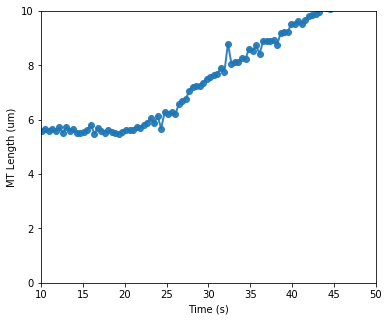

In [152]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

# if data.index.name == 'frame':
#     data = data.reset_index()
# data.to_csv(fname.with_suffix('.csv'), index=False)
# if data.index.name != 'frame':
#     data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(data['time_s'], data['length_um'],marker='o',linewidth=2,alpha=0.9) #facecolor='',edgecolor='b',s=60,

#ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
#plt.xlim(155,205)
plt.xlim(10,50)
#plt.ylim(3.6,3.9)
plt.ylim(0,10)
#plt.tight_layout()
ax.set_facecolor('w')
#fig.savefig(fname.with_suffix('.PLOT2.jpg'))


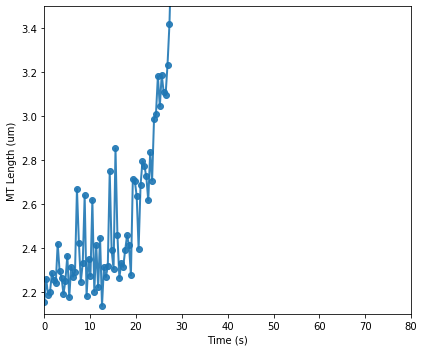

In [277]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

# if data.index.name == 'frame':
#     data = data.reset_index()
# data.to_csv(fname.with_suffix('.csv'), index=False)
# if data.index.name != 'frame':
#     data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(data['time_s'], data['length_um'], marker='o',linewidth=2,alpha=0.9) #facecolor='',edgecolor='b',s=60,

#ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
#plt.xlim(155,205)
plt.xlim(0,80)
#plt.ylim(3.6,3.9)
plt.ylim(2.1,3.5)
plt.tight_layout()
ax.set_facecolor('w')
#fig.savefig(fname.with_suffix('.PLOT2.jpg'))


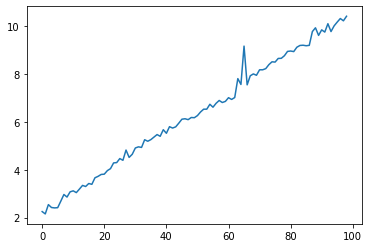

In [189]:
plt.plot(data['length_um'])


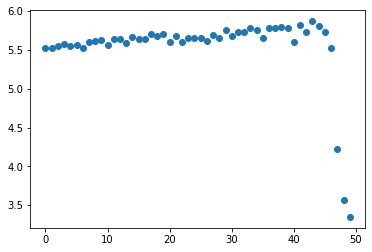

In [260]:
test1 = data['length_um'][750:800].to_list()
plt.scatter(np.arange(0,len(test1)), test1)

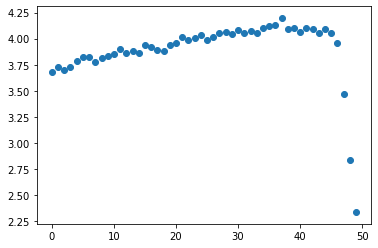

In [261]:
test2 = data['length_um'][236:286].to_list()
plt.scatter(np.arange(0,len(test2)), test2)

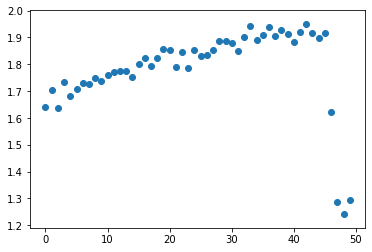

In [262]:
test3 = data['length_um'][329:379].to_list()
plt.scatter(np.arange(0,len(test3)), test3)

In [263]:
test1_2 = []
for i in test1:
    test1_2.append(i-test1[-4])
    
test2_2 = []
for i in test2:
    test2_2.append(i-test2[-4])

test3_2 = []
for i in test3:
    test3_2.append(i-test3[-4])

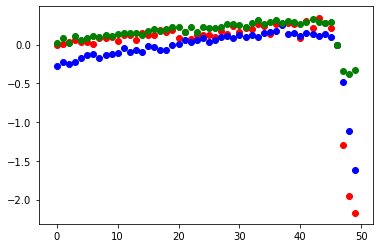

In [264]:
plt.scatter(np.arange(0,len(test1_2)), test1_2, color = 'r')
plt.scatter(np.arange(0,len(test2_2)), test2_2, color = 'b')
plt.scatter(np.arange(0,len(test3_2)), test3_2, color = 'g')

In [265]:
testavg = []
for i in np.arange(0,len(test1_2)):
    testavg.append((test1_2[i]+test2_2[i])/2)

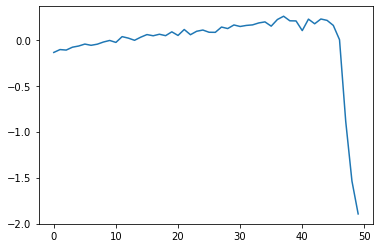

In [266]:
plt.plot(np.arange(0,len(testavg)),testavg)

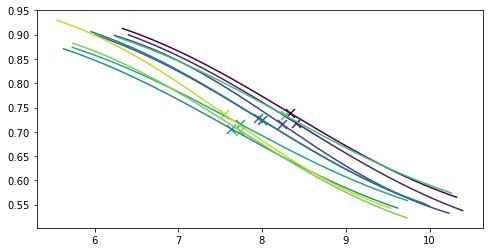

In [279]:


fig, ax = plt.subplots(figsize=(8, 4))

firstone = 410
lastone = 420
#lastone = 788

df = data.iloc[firstone:lastone]
i=0
for x_profile, y_profile, (_, row) in zip(x_profiles[firstone:lastone], y_profiles[firstone:lastone], df.iterrows()):
    
    pixlength = np.sqrt( (row['x']-data.loc[0, ['x']][0])**2 + (row['y']-data.loc[0, ['y']][0])**2 ) 
    
    args = row.to_dict()
    #args.pop('frame')
    args.pop('index')
    args.pop('time')
    args.pop('x')
    args.pop('y')
    args.pop('length_pixel')
    args.pop('length_um')
    args.pop('time_s')
    
    #x = np.arange(x_profile[0], x_profile[-2], 0.1)
    y_fitted = fit_func(row['mu'], **args)
    #y_fitted2 = fit_func(x, **args)

    #ax.plot(x_profile, y_profile)
    #ax.scatter(row['mu'], y_fitted, marker = 'x')
    #ax.plot(x, y_fitted2, alpha = 0.4)
    
    cmap = mpl.cm.viridis
    
    x = np.arange(pixlength-2,pixlength+2,0.01)
    args['mu'] = pixlength
    fitted_around = fit_func(x, **args)
    plt.plot(x, fitted_around, color=cmap(i / float(lastone-firstone)))

    ax.scatter(pixlength, y_fitted, marker = 'x', color=cmap(i / float(lastone-firstone)), s = 80)
    
    i+=1

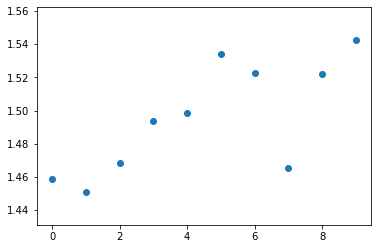

In [278]:
test1 = data['length_um'][410:420].to_list()
plt.scatter(np.arange(0,len(test1)), test1)

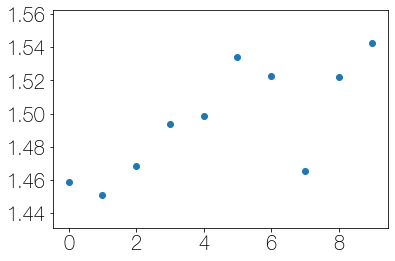

In [340]:
test1 = data['length_um'][410:420].to_list()
plt.rcParams['font.family'] ='Helvetica Neue Lt Std'
plt.scatter(np.arange(0,len(test1)), test1)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()